# Лабораторная работа №6: Градиентный бустинг

6132 Макарова Мария Константиновна Датасет: https://www.kaggle.com/datasets/stealthtechnologies/predict-people-personality-types

In [47]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report
import shap
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split

1. Считать в `pandas.DataFrame` любой источник данных: CSV, JSON, Excel-файл, HTML-таблицу и т.п.
   > Датасет должен содержать категориальные и количественные признаки.

In [48]:
data = pd.read_csv('data.csv')

2. Датасет и подготовка данных:
   - Привести описание датасета.
   - Осуществить предобработку данных (избавиться от `null`, убрать некоторые признаки и т.п.) - "подчистить данные".
   - Нормализовать численные данные.
   - Разбить выборку на обучающую и тестовую.
     > Из датафреймов обучающей и тестовой выборки необходимо сформировать два набора обучающей и тестовой выборок: с закодированными категориальными признаками и с категориальными признаками без обработки.


In [49]:
data.head()

,Age,Gender,Education,Introversion Score,Sensing Score,Thinking Score,Judging Score,Interest,Personality
0,21.0,Female,1,5.89208,2.144395,7.32363,5.462224,Arts,ENTP
1,24.0,Female,1,2.48366,3.206188,8.06876,3.765012,Unknown,INTP
2,26.0,Female,1,7.02910,6.469302,4.16472,5.454442,Others,ESFP
3,30.0,Male,0,5.46525,4.179244,2.82487,5.080477,Sports,ENFJ
4,31.0,Female,0,3.59804,6.189259,5.31347,3.677984,Others,ISFP


In [50]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43744 entries, 0 to 43743
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Age                 43744 non-null  float64
 1   Gender              43744 non-null  object 
 2   Education           43744 non-null  int64  
 3   Introversion Score  43744 non-null  float64
 4   Sensing Score       43744 non-null  float64
 5   Thinking Score      43744 non-null  float64
 6   Judging Score       43744 non-null  float64
 7   Interest            43744 non-null  object 
 8   Personality         43744 non-null  object 
dtypes: float64(5), int64(1), object(3)
memory usage: 3.0+ MB


In [51]:
description_list = [
    "Возраст индивида",
    "Пол индивида ('Male' или 'Female')",
    "Уровень образования: 1 — выпускник или выше, 0 — ниже (школа или без образования)",
    "Оценка интроверсии: от 0 до 10, выше — склонность к экстраверсии",
    "Оценка ощущений: от 0 до 10, выше — предпочтение ощущений над интуицией",
    "Оценка мышления: от 0 до 10, выше — предпочтение мышления над чувствами",
    "Оценка суждения: от 0 до 10, выше — предпочтение суждения над восприятием",
    "Основная область интересов индивида",
    "Тип личности"
]

dtypes_column = data.dtypes

df_info = pd.DataFrame({'Тип': dtypes_column, 'Описание': description_list})
pd.set_option('display.max_colwidth', None)
df_info

,Тип,Описание
Age,float64,Возраст индивида
Gender,object,Пол индивида ('Male' или 'Female')
Education,int64,"Уровень образования: 1 — выпускник или выше, 0 — ниже (школа или без образования)"
Introversion Score,float64,"Оценка интроверсии: от 0 до 10, выше — склонность к экстраверсии"
Sensing Score,float64,"Оценка ощущений: от 0 до 10, выше — предпочтение ощущений над интуицией"
Thinking Score,float64,"Оценка мышления: от 0 до 10, выше — предпочтение мышления над чувствами"
Judging Score,float64,"Оценка суждения: от 0 до 10, выше — предпочтение суждения над восприятием"
Interest,object,Основная область интересов индивида
Personality,object,Тип личности


In [52]:
X = data.drop('Education', axis=1)
y = data['Education']

numeric_features = X.select_dtypes(include=['float64','int64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

scaler = MinMaxScaler()
X[numeric_features] = pd.DataFrame(scaler.fit_transform(X[numeric_features]),columns=numeric_features)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [53]:
print(data['Interest'].value_counts())
print()
print(data['Gender'].value_counts())
print()
print(data['Personality'].value_counts())

Interest
Unknown       15396
Arts           8450
Sports         7029
Others         6809
Technology     6060
Name: count, dtype: int64

Gender
Male      24155
Female    19589
Name: count, dtype: int64

Personality
ENTP    2734
INTP    2734
ESFP    2734
ENFJ    2734
ISFP    2734
ISFJ    2734
ESTJ    2734
INFP    2734
ESTP    2734
ENFP    2734
INTJ    2734
ESFJ    2734
ISTJ    2734
INFJ    2734
ISTP    2734
ENTJ    2734
Name: count, dtype: int64


In [54]:
X_train_encoded = X_train.copy()
encoder = LabelEncoder()
X_train_encoded[categorical_features] = X_train_encoded[categorical_features].apply(encoder.fit_transform)

X_test_encoded = X_test.copy()
encoder = LabelEncoder()
X_test_encoded[categorical_features] = X_test_encoded[categorical_features].apply(encoder.fit_transform)

In [55]:
X_test.head()

,Age,Gender,Introversion Score,Sensing Score,Thinking Score,Judging Score,Interest,Personality
5525,0.294118,Male,0.583047,0.638828,0.875022,0.663469,Unknown,ESTP
8279,0.529412,Male,0.377298,0.637275,0.407219,0.636345,Others,ISFP
18282,0.235294,Male,0.274191,0.332807,0.593046,0.516423,Unknown,INFP
22198,0.264706,Female,0.125835,0.667352,0.400156,0.326718,Unknown,ISFP
12483,0.088235,Female,0.729145,0.464206,0.862374,0.417349,Technology,ENTP


In [56]:
X_test_encoded.head()

,Age,Gender,Introversion Score,Sensing Score,Thinking Score,Judging Score,Interest,Personality
5525,0.294118,1,0.583047,0.638828,0.875022,0.663469,4,7
8279,0.529412,1,0.377298,0.637275,0.407219,0.636345,1,13
18282,0.235294,1,0.274191,0.332807,0.593046,0.516423,4,9
22198,0.264706,0,0.125835,0.667352,0.400156,0.326718,4,13
12483,0.088235,0,0.729145,0.464206,0.862374,0.417349,3,3


3. Для каждого из классификаторов ($AdaBoost$, $GradientBoostingClassifier$, $XGBoost$, $CatBoost$):
   - С использованием `GridSearchCV`/`grid_search` осуществить подбор гиперпараметра модели, использовать выборки с закодированными категориальными признаками.
     > Как минимум основных: `n_estimators`/`iterations`, `learning_rate`, `depth`, параметры регуляризации $L^1$, $L^2$. Для ускорения вычислений можно сразу с заданным значением `early_stopping_rounds` &ndash; тогда понадобится еще выделить валидационный датасет ($XGBoost$) или задать значение `train_size` у $CatBoost$ (часть обучающей выборки пойдет в валидационный набор).
   - Обучить модели $XGBoost$ и $CatBoost$ с найденными гиперпараметрами на обучающей выборке с категориальными признаками "как есть".
   - Итого получить 6 обученных моделей.
   - Вывести метрики на тестовом наборе (как минимум `classification_report`, другие по желанию).
   - Сравнить модели, выбрать лучшую.
     > Ожидаемый результат &ndash; $XGBoost$/$CatBoost$.

In [57]:
param_grid_ada = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 1]
}

ada = AdaBoostClassifier(random_state=42)
grid_ada = GridSearchCV(ada, param_grid_ada, cv=3, scoring='f1_macro', n_jobs=-1)
grid_ada.fit(X_train_encoded, y_train)
best_ada = grid_ada.best_estimator_

In [58]:
param_grid_gb = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5]
}

gb = GradientBoostingClassifier(random_state=42)
grid_gb = GridSearchCV(gb, param_grid_gb, cv=3, scoring='f1_macro', n_jobs=-1)
grid_gb.fit(X_train_encoded, y_train)
best_gb = grid_gb.best_estimator_

In [59]:
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

param_grid_xgb = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5],
    'reg_alpha': [0, 1],
    'reg_lambda': [1, 10]
}

grid_xgb = GridSearchCV(xgb, param_grid_xgb, cv=3, scoring='f1_macro', n_jobs=-1)
grid_xgb.fit(X_train_encoded, y_train)
best_xgb = grid_xgb.best_estimator_

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [23:39:31] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [60]:
cat = CatBoostClassifier(verbose=0, random_state=42)

param_grid_cat = {
    'iterations': [200, 500],
    'learning_rate': [0.01, 0.1],
    'depth': [4, 6],
    'l2_leaf_reg': [1, 10]
}

grid_cat = GridSearchCV(cat, param_grid_cat, cv=3, scoring='f1_macro', n_jobs=-1)
grid_cat.fit(X_train_encoded, y_train)
best_cat = grid_cat.best_estimator_

In [61]:
print("Лучшие параметры для AdaBoost:")
print(grid_ada.best_params_)

print("Лучшие параметры для GradientBoosting:")
print(grid_gb.best_params_)

print("Лучшие параметры для XGBoost:")
print(grid_xgb.best_params_)

print("Лучшие параметры для CatBoost:")
print(grid_cat.best_params_)

Лучшие параметры для AdaBoost:
{'learning_rate': 1, 'n_estimators': 100}
Лучшие параметры для GradientBoosting:
{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}
Лучшие параметры для XGBoost:
{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'reg_alpha': 1, 'reg_lambda': 1}
Лучшие параметры для CatBoost:
{'depth': 6, 'iterations': 500, 'l2_leaf_reg': 1, 'learning_rate': 0.1}


In [70]:
for col in ['Gender', 'Interest', 'Personality']:
    X_train[col] = X_train[col].astype('category')
    X_test[col] = X_test[col].astype('category')


xgb_noEncoded = XGBClassifier(**grid_xgb.best_params_, enable_categorical=True)

xgb_noEncoded.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=True, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [71]:
cat_features = X_train.select_dtypes(include='category').columns.tolist()

catboost_noEncoded = CatBoostClassifier(**grid_cat.best_params_, cat_features=cat_features)

catboost_noEncoded.fit(X_train, y_train)

0:	learn: 0.5483257	total: 101ms	remaining: 50.4s
1:	learn: 0.4467998	total: 176ms	remaining: 43.9s
2:	learn: 0.4010059	total: 256ms	remaining: 42.3s
3:	learn: 0.3719502	total: 367ms	remaining: 45.5s
4:	learn: 0.3516286	total: 440ms	remaining: 43.6s
5:	learn: 0.3503569	total: 485ms	remaining: 39.9s
6:	learn: 0.3390260	total: 562ms	remaining: 39.6s
7:	learn: 0.3381698	total: 665ms	remaining: 40.9s
8:	learn: 0.3310371	total: 710ms	remaining: 38.7s
9:	learn: 0.3306286	total: 735ms	remaining: 36s
10:	learn: 0.3303330	total: 760ms	remaining: 33.8s
11:	learn: 0.3299321	total: 810ms	remaining: 33s
12:	learn: 0.3260808	total: 916ms	remaining: 34.3s
13:	learn: 0.3258375	total: 982ms	remaining: 34.1s
14:	learn: 0.3241572	total: 1.05s	remaining: 33.9s
15:	learn: 0.3219929	total: 1.1s	remaining: 33.4s
16:	learn: 0.3219530	total: 1.13s	remaining: 32.1s
17:	learn: 0.3217042	total: 1.22s	remaining: 32.6s
18:	learn: 0.3216323	total: 1.31s	remaining: 33.2s
19:	learn: 0.3215404	total: 1.38s	remaining: 3

In [73]:
models = {
    "AdaBoost": best_ada,
    "GradientBoosting": best_gb,
    "XGBoost": best_xgb,
    "CatBoost": best_cat
}

for name, model in models.items():
    y_pred = model.predict(X_test_encoded)
    print(f"\nModel: {name}")
    print(classification_report(y_test, y_pred,digits = 6))


Model: AdaBoost
              precision    recall  f1-score   support

           0   0.770717  1.000000  0.870514      6743
           1   0.000000  0.000000  0.000000      2006

    accuracy                       0.770717      8749
   macro avg   0.385358  0.500000  0.435257      8749
weighted avg   0.594004  0.770717  0.670919      8749


Model: GradientBoosting
              precision    recall  f1-score   support

           0   0.806706  0.970488  0.881050      6743
           1   0.687598  0.218345  0.331442      2006

    accuracy                       0.798034      8749
   macro avg   0.747152  0.594416  0.606246      8749
weighted avg   0.779397  0.798034  0.755034      8749


Model: XGBoost
              precision    recall  f1-score   support

           0   0.805743  0.973751  0.881816      6743
           1   0.705000  0.210867  0.324635      2006

    accuracy                       0.798834      8749
   macro avg   0.755372  0.592309  0.603226      8749
weighted avg   0

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           0   0.817300  0.950022  0.878678      6743
           1   0.630077  0.286142  0.393555      2006

    accuracy                       0.797805      8749
   macro avg   0.723689  0.618082  0.636116      8749
weighted avg   0.774373  0.797805  0.767447      8749



In [75]:
y_pred = xgb_noEncoded.predict(X_test)
print(f"Model: XGB_noEncoded ")
print(classification_report(y_test, y_pred,digits = 6))

Model: XGB_noEncoded 
              precision    recall  f1-score   support

           0   0.814250  0.966039  0.883674      6743
           1   0.694259  0.259222  0.377495      2006

    accuracy                       0.803978      8749
   macro avg   0.754255  0.612631  0.630585      8749
weighted avg   0.786738  0.803978  0.767615      8749



In [76]:
y_pred = catboost_noEncoded.predict(X_test)
print(f"Model: Catboost_noEncoded ")
print(classification_report(y_test, y_pred,digits = 6))

Model: Catboost_noEncoded 
              precision    recall  f1-score   support

           0   0.818980  0.954768  0.881676      6743
           1   0.656532  0.290628  0.402903      2006

    accuracy                       0.802492      8749
   macro avg   0.737756  0.622698  0.642289      8749
weighted avg   0.781733  0.802492  0.771901      8749



По accuracy и weighted avg F1 — лучшие модели это XGB_noEncoded и Catboost_noEncoded. У Catboost в общем у большинства метрик значение выше, так что берем его как лучшую модель.

4. Важность признаков:
   - С использованием `shap.TreeExplainer` получить $SHAP$-значения для лучшей модели.
   - Построить график `shap.plots.force` для одного объекта выборки и для среза произвольного размера.
   - Построить график `shap.plots.bar` для одного объекта выборки.
   - Построить график `shap.plots.waterfall` для одного объекта выборки.
   - Построить 2 графика `shap.plots.scatter` для какого-нибудь признака. На одном раскрасить относительно себя, на втором &ndash; относительно другого признака.
   - Построить график `shap.plots.beeswarm` для всех признаков.
   - Построить график `shap.plots.bar` для всех признаков.
   - На основании двух последних графиков и/или используя `feature_importance` отфильровать признаки (отразить сформулированные выводы в тексте), переобучить лучшую модель.
   - Сравнить метрики до и после фильтрации.
   - Визуализировать полученное дерево решений.

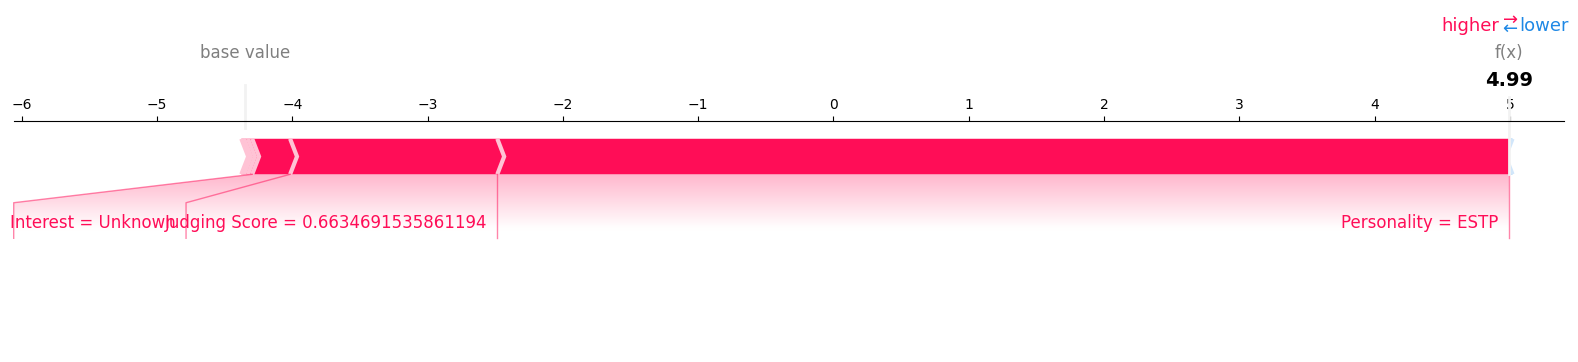

In [82]:
explainer = shap.TreeExplainer(catboost_noEncoded)
shap_values = explainer.shap_values(X_test)

shap.plots.force(explainer.expected_value, shap_values[0, :], X_test.iloc[0, :], matplotlib=True)

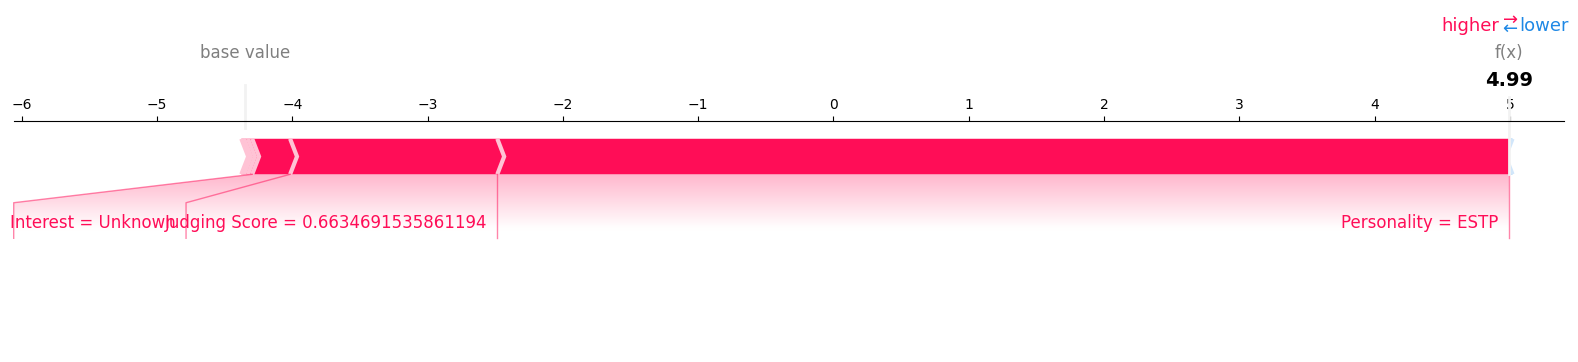

In [87]:
shap.plots.force(explainer.expected_value, shap_values[0, :100], X_test.iloc[0, :100], matplotlib=True)

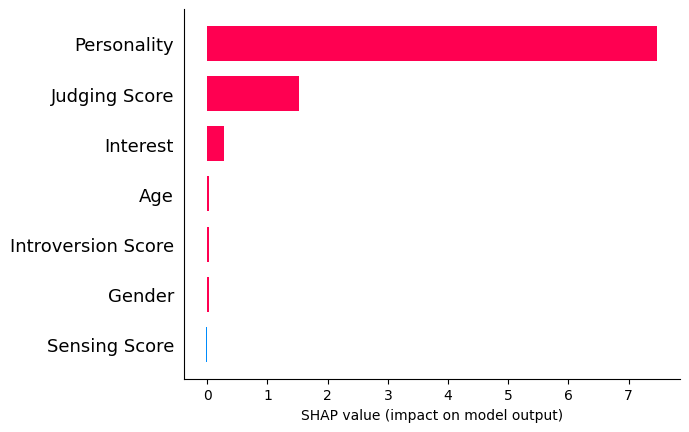

In [102]:
shap.bar_plot(shap_values[0, :], feature_names=X_train.columns)

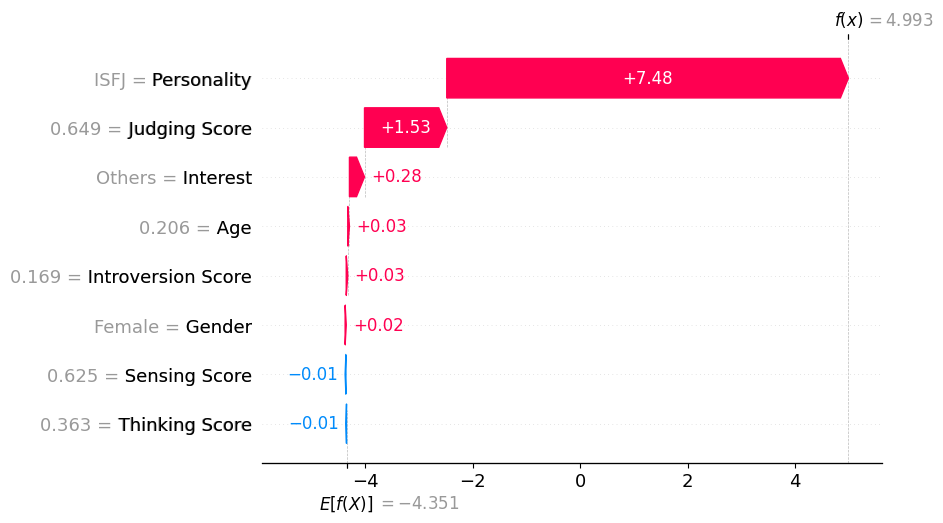

In [93]:
shap_exp = shap.Explanation(values=shap_values[0, :], base_values=explainer.expected_value, data=X_train.iloc[0, :], feature_names=X_train.columns)
shap.plots.waterfall(shap_exp)

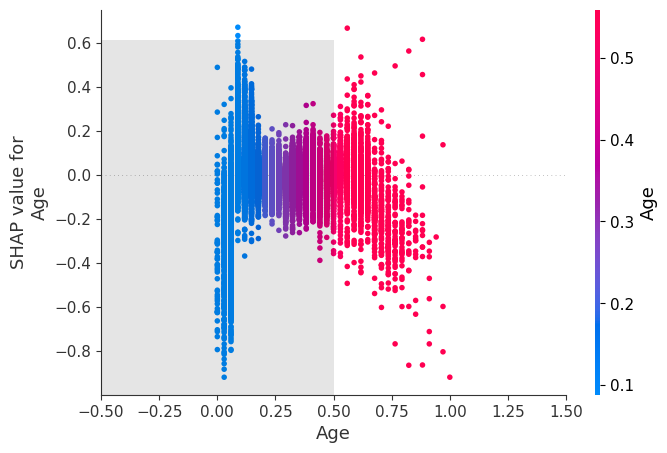

In [96]:
feature_of_interest = 'Age'
shap.plots.scatter(explainer(X_train)[:, feature_of_interest], color=explainer(X_train)[:, feature_of_interest])

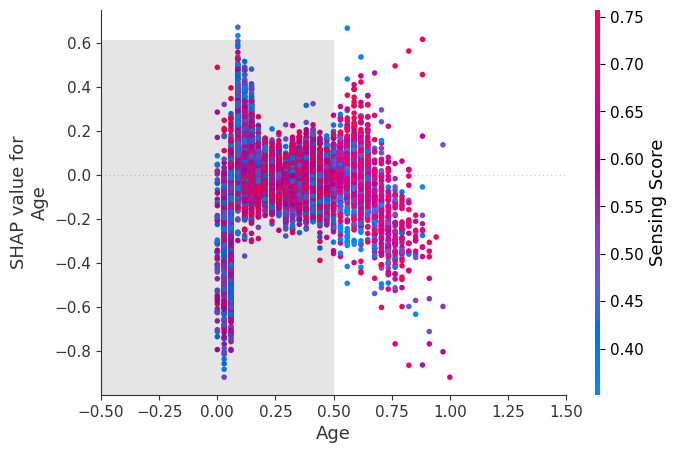

In [97]:
feature_of_interest2 = 'Sensing Score'
shap.initjs()
shap.plots.scatter(explainer(X_train)[:, feature_of_interest], color=explainer(X_train)[:, feature_of_interest2])

<Axes: xlabel='SHAP value (impact on model output)'>

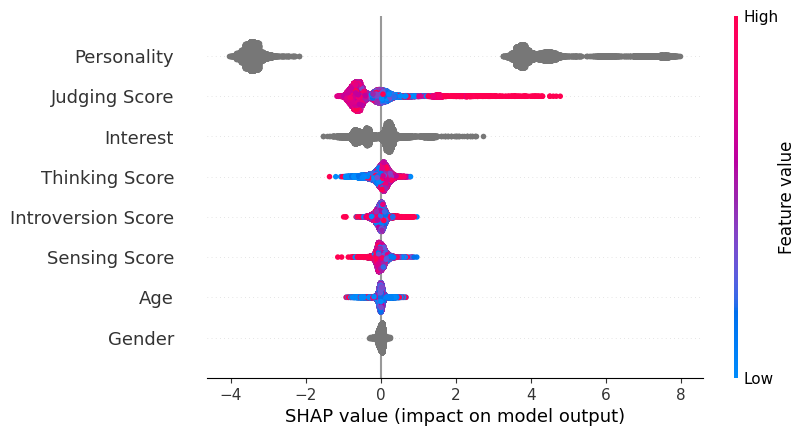

In [98]:
shap.plots.beeswarm(explainer(X_train), max_display=X_train.shape[1], show=False)

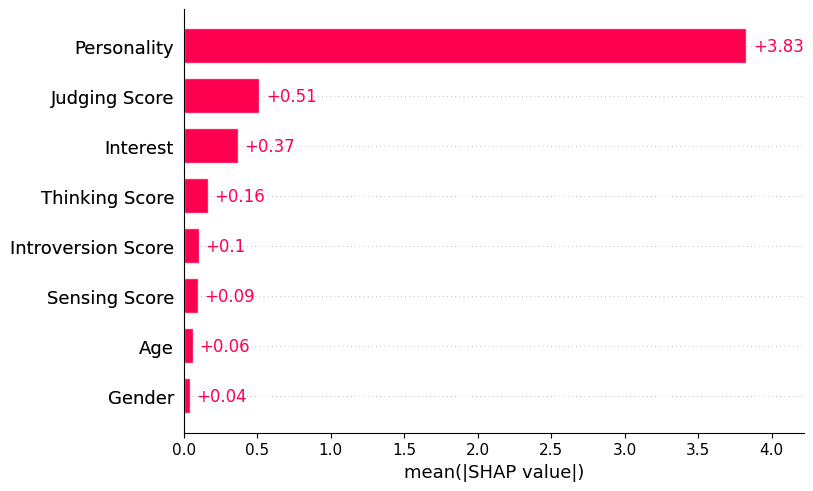

In [99]:
shap_bp = shap.plots.bar(explainer(X_train), max_display=X_train.shape[1])

In [103]:
importance = pd.DataFrame({'Feature': X_train.columns,'Importance': model.feature_importances_}).sort_values(by='Importance', ascending=False)
print(importance)

              Feature  Importance
7         Personality   67.964021
5       Judging Score   14.256858
4      Thinking Score    5.949548
3       Sensing Score    4.483629
2  Introversion Score    3.220776
6            Interest    1.775619
0                 Age    1.769094
1              Gender    0.580454


In [104]:
selected_features = importance[importance['Importance'] > 2]['Feature']
selected_features

,Feature
7,Personality
5,Judging Score
4,Thinking Score
3,Sensing Score
2,Introversion Score


In [106]:
X_train_selected= X_train[selected_features]
X_test_selected = X_test[selected_features]

cat_features_selected = X_train_selected.select_dtypes(include='category').columns.tolist()

catboost_noEncoded_selected = CatBoostClassifier(**grid_cat.best_params_, cat_features=cat_features_selected)

catboost_noEncoded_selected.fit(X_train_selected, y_train)

y_pred_selected = catboost_noEncoded_selected.predict(X_test_selected)
print(classification_report(y_test, y_pred_selected,digits = 6))

0:	learn: 0.5555317	total: 99.9ms	remaining: 49.9s
1:	learn: 0.4587270	total: 185ms	remaining: 46s
2:	learn: 0.4031960	total: 261ms	remaining: 43.3s
3:	learn: 0.3739462	total: 362ms	remaining: 44.9s
4:	learn: 0.3561170	total: 442ms	remaining: 43.8s
5:	learn: 0.3545188	total: 507ms	remaining: 41.8s
6:	learn: 0.3430019	total: 605ms	remaining: 42.6s
7:	learn: 0.3363586	total: 765ms	remaining: 47s
8:	learn: 0.3321507	total: 850ms	remaining: 46.3s
9:	learn: 0.3317767	total: 925ms	remaining: 45.3s
10:	learn: 0.3292886	total: 1.06s	remaining: 47.2s
11:	learn: 0.3290042	total: 1.22s	remaining: 49.6s
12:	learn: 0.3287417	total: 1.29s	remaining: 48.4s
13:	learn: 0.3272317	total: 1.37s	remaining: 47.4s
14:	learn: 0.3260154	total: 1.44s	remaining: 46.7s
15:	learn: 0.3250198	total: 1.52s	remaining: 45.9s
16:	learn: 0.3243359	total: 1.6s	remaining: 45.4s
17:	learn: 0.3239143	total: 1.69s	remaining: 45.3s
18:	learn: 0.3236008	total: 1.76s	remaining: 44.5s
19:	learn: 0.3232624	total: 1.82s	remaining: 

Разница невелика, но в предыдущем случае было лучше, последние результаты немного ухудшились

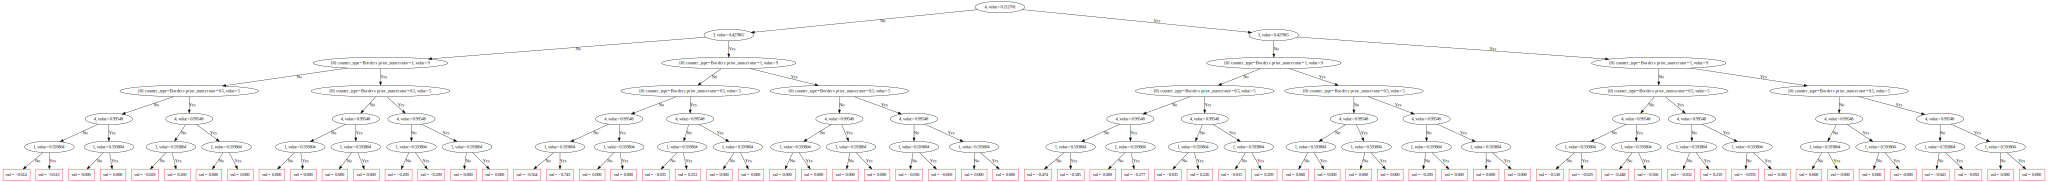

In [111]:
catboost_noEncoded_selected.plot_tree(tree_idx=0)

5. Регрессия:
   - С использованием `GridSearchCV`/`grid_search` осуществить подбор гиперпараметра модели линейной регрессии с использованием $XGBoost$ или $CatBoost$.
     > [xgboost.XGBRegressor](https://xgboost.readthedocs.io/en/stable/python/python_api.html#xgboost.XGBRegressor) в $XGBoost$, [CatBoostRegressor](https://catboost.ai/en/docs/concepts/python-reference_catboostregressor) в $CatBoost$. В целом, можно выбрать новый таргет из уже полученного разбиения на обучающую и тестовыую выборки из пункта 2.
   - Вывести метрики $MSE$, $MAE$ и $R^2$ на тестовом наборе.
   - Переобучить модель на отфильтрованном наборе признаков из пункта 4.
   - Сравнить метрики до и после фильтрации.

In [112]:
data = pd.read_csv('data.csv')
numeric_features = data.select_dtypes(include=['float64','int64']).columns
categorical_features = data.select_dtypes(include=['object']).columns
scaler = StandardScaler()
encoder = LabelEncoder()
data[numeric_features] = scaler.fit_transform(data[numeric_features])
data[categorical_features] = data[categorical_features].apply(encoder.fit_transform)

In [117]:
from xgboost import XGBRegressor

target = 'Thinking Score'
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(data.drop(columns=[target]), data[target], test_size=0.2, random_state=42)

xgb_params = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5]
}

xgb_reg = XGBRegressor(random_state=42)
grid_reg = GridSearchCV(xgb_reg, xgb_params, cv=5, scoring='neg_mean_squared_error')
grid_reg.fit(X_train_new, y_train_new)
xgb_best_reg = grid_reg.best_estimator_
xgb_best_reg.fit(X_train_new, y_train_new)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [118]:
y_pred_xgb = xgb_best_reg.predict(X_test_new)

mse_xgb = mean_squared_error(y_test_new, y_pred_xgb)
mae_xgb = mean_absolute_error(y_test_new, y_pred_xgb)
r2_xgb = r2_score(y_test_new, y_pred_xgb)

print(f"MSE: {mse_xgb} \nMAE: {mae_xgb} \nR^2: {r2_xgb}")

MSE: 0.26514448352594727 
MAE: 0.4362140004570352 
R^2: 0.7329694551255358


In [123]:
X_train_new_selected = X_train_new[selected_features.drop(index=4)]
X_test_new_selected = X_test_new[selected_features.drop(index=4)]

xgb_reg_selected = grid_reg.best_estimator_
xgb_reg_selected.fit(X_train_new_selected,y_train_new)
y_pred_xgb_selected = xgb_reg_selected.predict(X_test_new_selected)


mse_xgb_filtered = mean_squared_error(y_test_new, y_pred_xgb_selected)
mae_xgb_filtered = mean_absolute_error(y_test_new, y_pred_xgb_selected)
r2_xgb_filtered = r2_score(y_test_new, y_pred_xgb_selected)

print(f"MSE: {mse_xgb_filtered} \nMAE: {mae_xgb_filtered} \nR^2: {r2_xgb_filtered}")

MSE: 0.27749260149622573 
MAE: 0.44449585085017557 
R^2: 0.7205335008641871


In [124]:
print("Сравнение метрик до и после фильтрации признаков:")
print(f"MSE: {mse_xgb} -> {mse_xgb_filtered}")
print(f"MAE: {mae_xgb} -> {mae_xgb_filtered}")
print(f"R^2: {r2_xgb} -> {r2_xgb_filtered}")

Сравнение метрик до и после фильтрации признаков:
MSE: 0.26514448352594727 -> 0.27749260149622573
MAE: 0.4362140004570352 -> 0.44449585085017557
R^2: 0.7329694551255358 -> 0.7205335008641871


Как можно заметить, MSE и MAE ухудшились, а R^2 улучшилась.